Forecast the Airlines Passengers data set. Prepare a document for each model explaining
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for
Forecasting.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
import plotly.express as px
from scipy.stats import boxcox
import plotly.graph_objects as go
from pandas.plotting import lag_plot
import statsmodels.formula.api as smf
from plotly.subplots import make_subplots
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
uploaded=files.upload()

Saving Airlines+Data.xlsx to Airlines+Data.xlsx


In [12]:
airline_df = pd.read_excel('Airlines+Data.xlsx')
airline_df

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


# **EDA**

In [4]:
airline_df.shape

(96, 2)

In [5]:
airline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [6]:
airline_df.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [9]:
airline_df[airline_df.duplicated()]

,Month,Passengers


In [14]:
airline_df.rename({'Month':'Date'}, axis=1, inplace=True)

In [15]:
airline = airline_df.copy()
airline.set_index('Date', inplace=True)
airline.index.year

Int64Index([1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995,
            1995, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996,
            1996, 1996, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997,
            1997, 1997, 1997, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998,
            1998, 1998, 1998, 1998, 1999, 1999, 1999, 1999, 1999, 1999, 1999,
            1999, 1999, 1999, 1999, 1999, 2000, 2000, 2000, 2000, 2000, 2000,
            2000, 2000, 2000, 2000, 2000, 2000, 2001, 2001, 2001, 2001, 2001,
            2001, 2001, 2001, 2001, 2001, 2001, 2001, 2002, 2002, 2002, 2002,
            2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002],
           dtype='int64', name='Date')

In [16]:
airline

,Passengers
Date,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


In [17]:
airline_df["Date"]  = pd.to_datetime(airline_df.Date, format="%b-%y")
airline_df["month"] = airline_df.Date.dt.strftime("%b") # month extraction
airline_df["year"]  = airline_df.Date.dt.strftime("%Y") # year extraction
airline_df.head(10)

,Date,Passengers,month,year
0,1995-01-01,112,Jan,1995
1,1995-02-01,118,Feb,1995
2,1995-03-01,132,Mar,1995
3,1995-04-01,129,Apr,1995
4,1995-05-01,121,May,1995
5,1995-06-01,135,Jun,1995
6,1995-07-01,148,Jul,1995
7,1995-08-01,148,Aug,1995
8,1995-09-01,136,Sep,1995
9,1995-10-01,119,Oct,1995


# **Data Visualization**

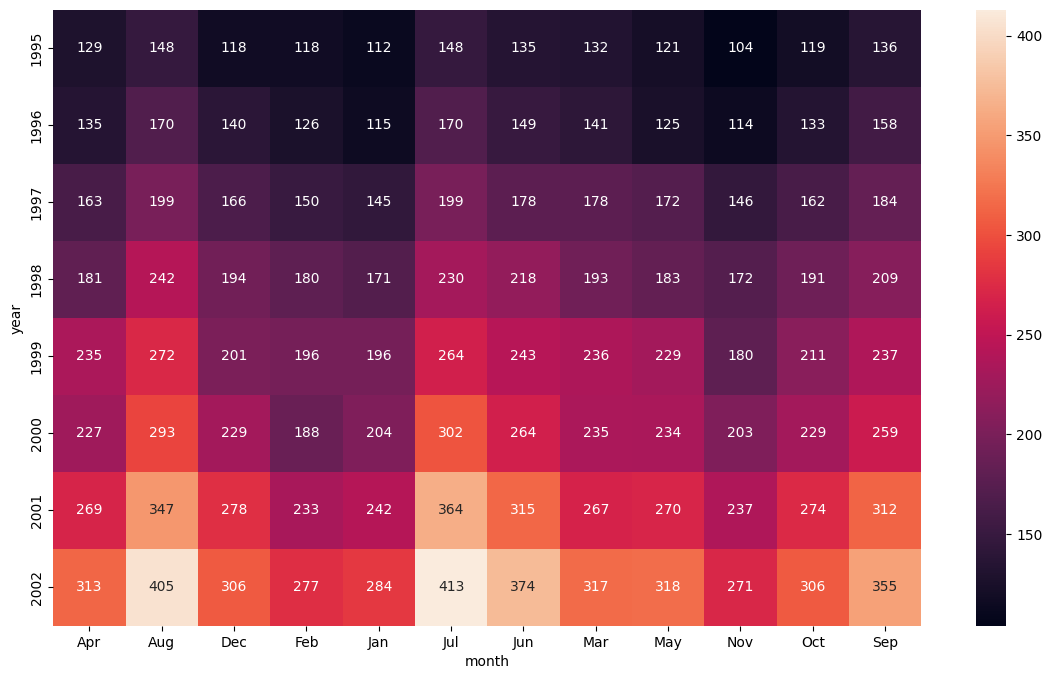

In [18]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=airline_df,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")
plt.show()

# Line plot

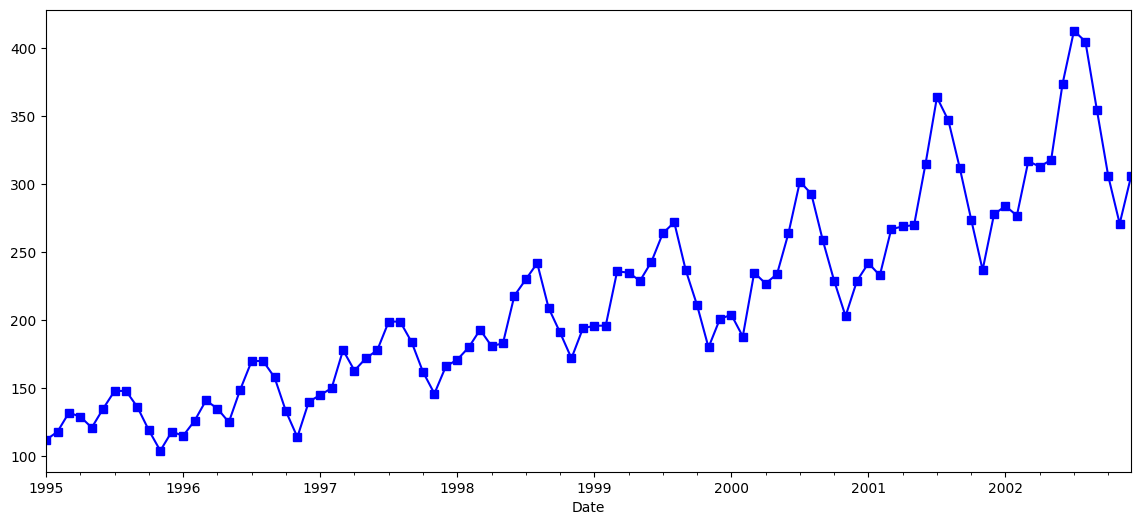

In [19]:
airline['Passengers'].plot(figsize=(14,6), color='blue', marker='s')
plt.show()

# Histogram and Density Plots

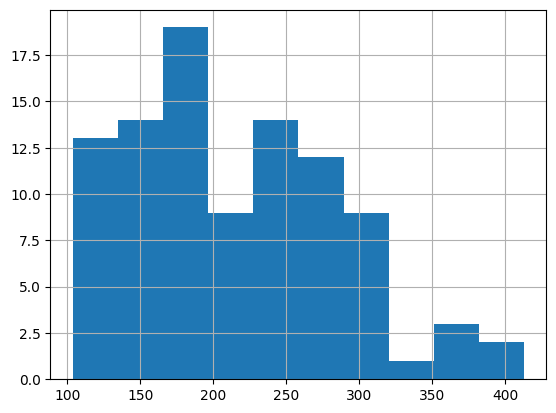

In [20]:
airline['Passengers'].hist()
plt.show()

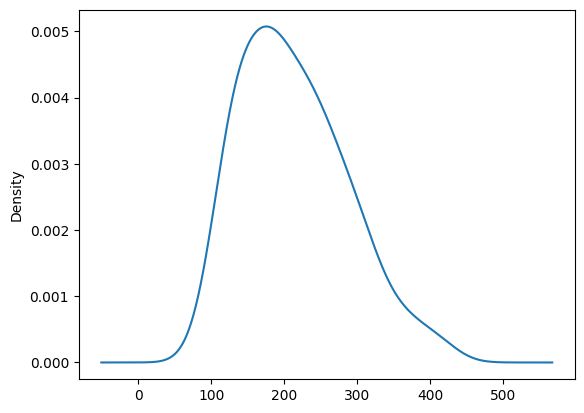

In [21]:
airline['Passengers'].plot(kind='kde')
plt.show()

# Lag plot

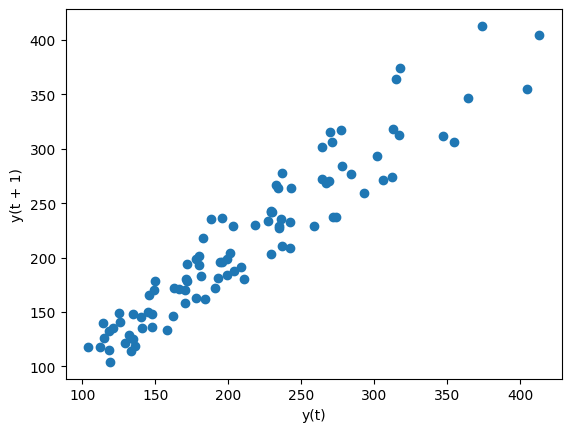

In [22]:
# create a scatter plot
lag_plot(airline['Passengers'])
plt.show()

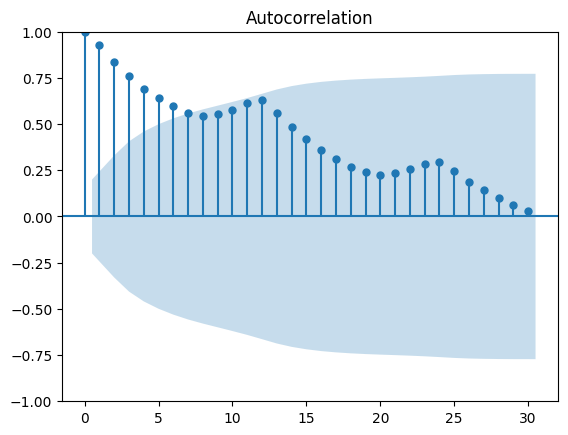

In [23]:
# create an autocorrelation plot
plot_acf(airline['Passengers'],lags=30)
plt.show()

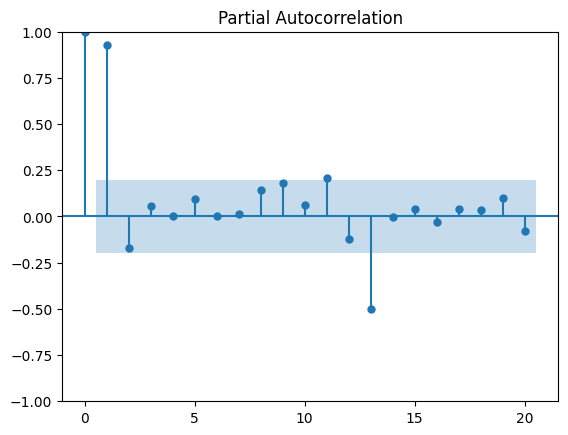

In [24]:
# create an Partial Autocorrelation
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_pacf(airline['Passengers'],lags=20)
plt.show()

# **Splitting Train and Test Data**

In [25]:
train_data = airline[:72]
test_data = airline[72:]

In [26]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1995-01-01 00:00:00 2000-12-01 00:00:00 
 Test: 2001-01-01 00:00:00 2002-12-01 00:00:00


# Evaluation Metric MAPE

In [27]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

# **Exponential Methods**

# Simple Exponential Method

In [28]:
ses_model = SimpleExpSmoothing(train_data['Passengers']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Passengers))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Passengers)

In [29]:
test_rmse_ses

91.11325402904403

In [30]:
train_rmse_ses

19.031771730910982

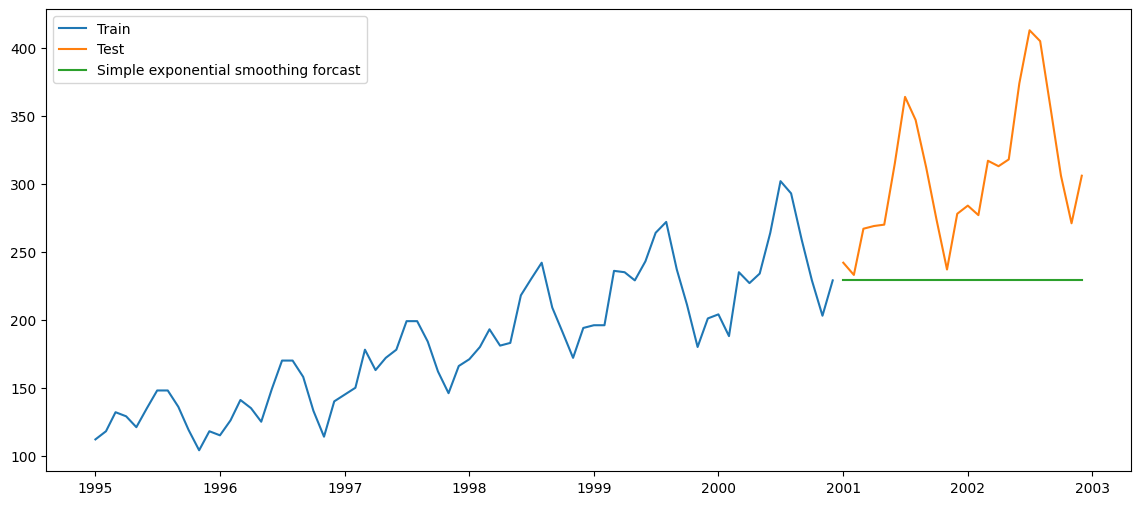

In [31]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

# Holt method

In [32]:
hw_model = Holt(train_data['Passengers']).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = test_data.index[0],end = test_data.index[-1])
MAPE(pred_hw,test_data['Passengers'])

41.15051047437214

# Holts winter exponential smoothing with additive seasonality and additive trend

In [33]:
hwe_model_add_add = ExponentialSmoothing(train_data['Passengers'],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test_data.index[0],end = test_data.index[-1])
MAPE(pred_hwe_add_add,test_data['Passengers'])

12.084813658780355

# Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [34]:
hwe_model_mul_add = ExponentialSmoothing(train_data['Passengers'],seasonal="mul",trend="add",seasonal_periods=12).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test_data.index[0],end = test_data.index[-1])
MAPE(pred_hwe_mul_add,test_data.Passengers)

9.368409298996491

# **Feature Scaling (Transformations)**

# 1. Square Root Transform

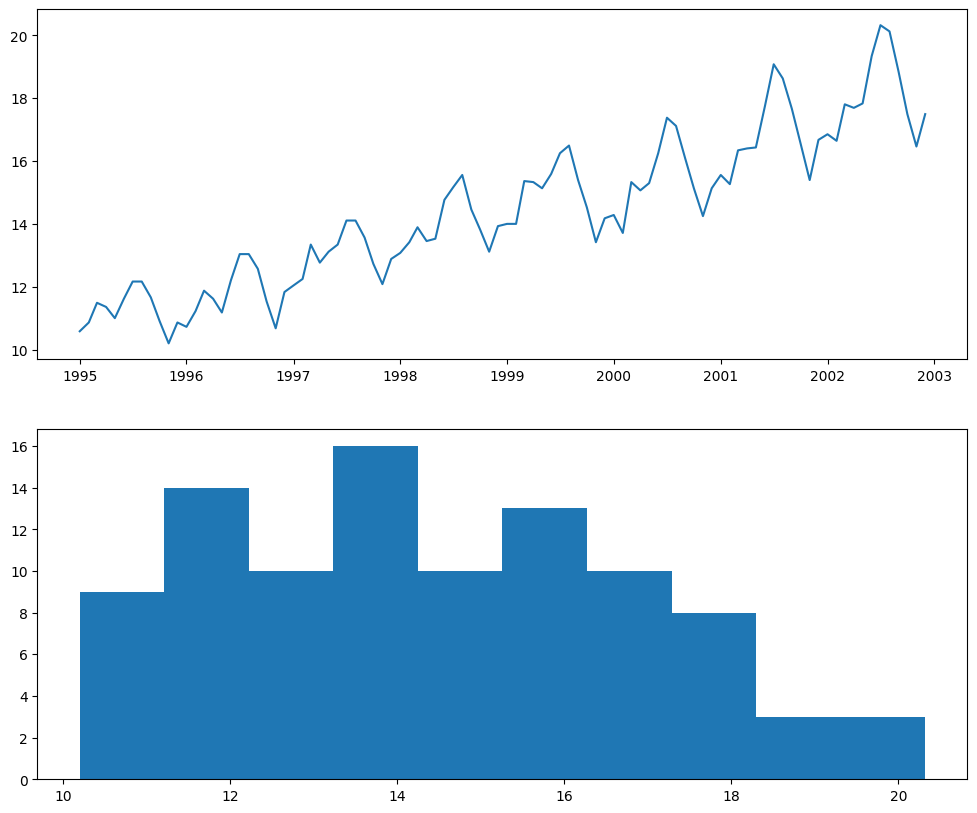

In [36]:
square_root= pd.DataFrame()
square_root = airline[['Passengers']]
square_root['Passengers'] = np.sqrt(square_root.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Passengers'])

# Histogram
plt.subplot(212)
plt.hist(square_root['Passengers'])
plt.show()

# 2. Log Transform

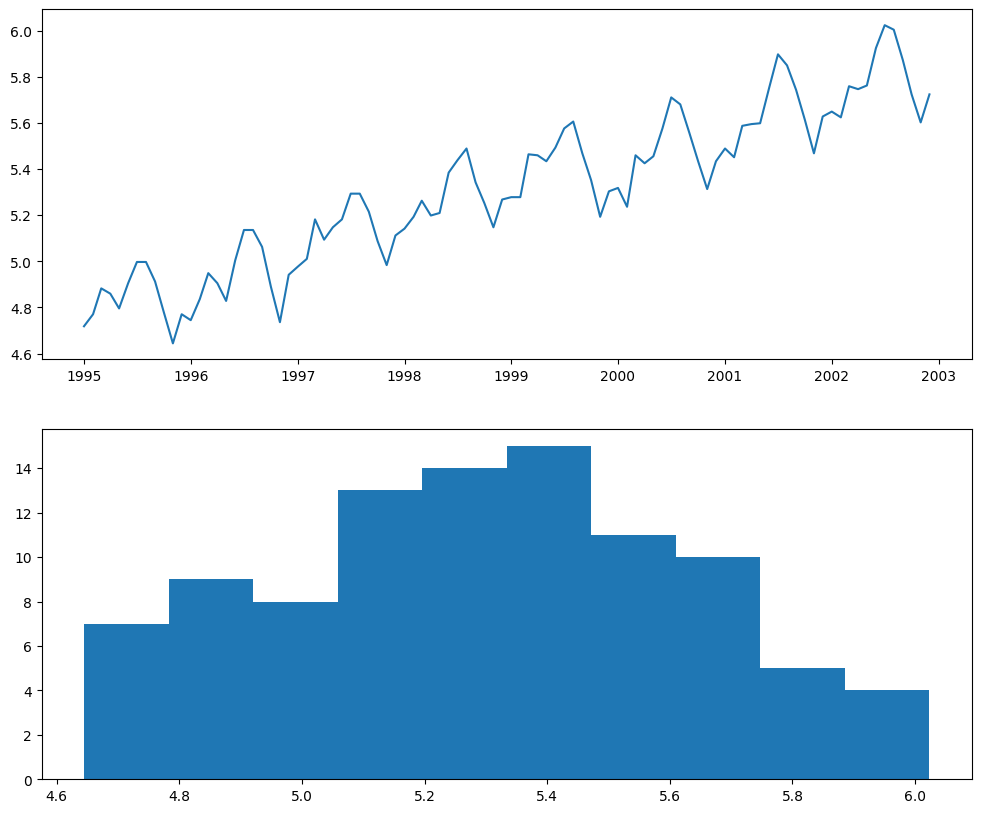

In [37]:
log = pd.DataFrame()
log = airline[['Passengers']]
log['Passengers'] = np.log(log.Passengers)

# line chart
fig = plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Passengers'])

# Histogram
plt.subplot(212)
plt.hist(log['Passengers'])
plt.show()

# 3)Box Cox Transformation

,Passengers
Date,
1995-01-01,4.718499
1995-02-01,4.770685
1995-03-01,4.882802
1995-04-01,4.859812
1995-05-01,4.795791


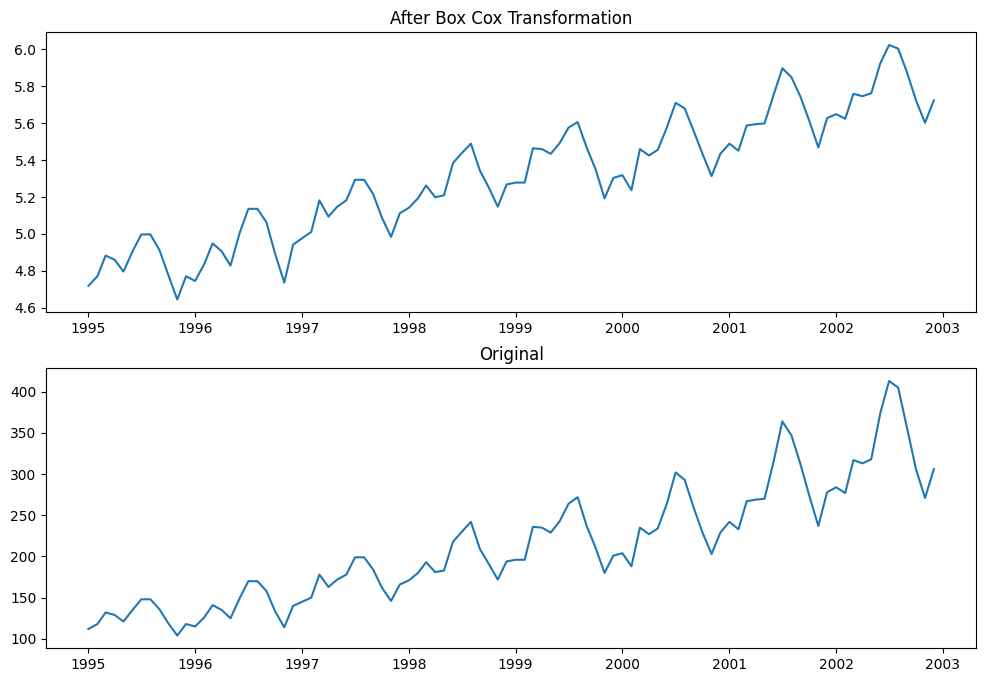

In [38]:
data_boxcox = pd.DataFrame()
data_boxcox['Passengers'] = pd.Series(boxcox(airline['Passengers'], lmbda=0), airline.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(12,8),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(airline, label='original')
axis[1].set_title('Original')
plt.show()

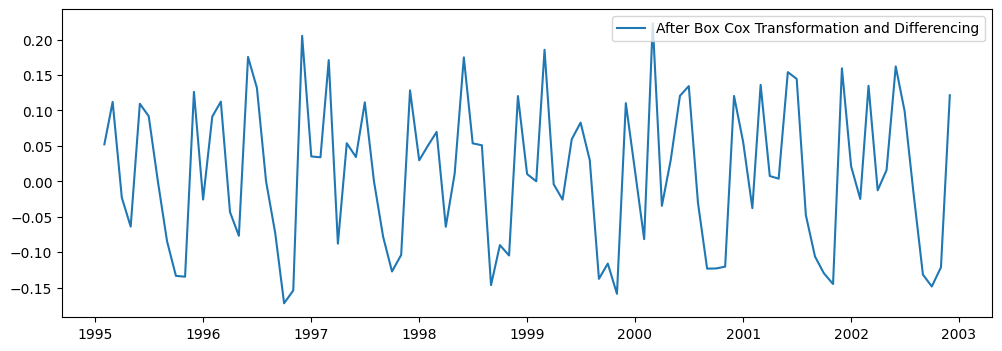

In [39]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

# **Building The Time Series Forecasting with Optimal Value using ARIMA**

In [41]:
train_data_boxcox = data_boxcox[:72]
test_data_boxcox = data_boxcox[72:]
train_data_boxcox_diff = data_boxcox_diff[:72]
test_data_boxcox_diff = data_boxcox_diff[72:]

In [42]:
def evaluate_arima_model(X, arima_order):

# Prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

# Make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

# Calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [45]:
# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [46]:
# Evaluate parameters
p_values = range(0,5)
d_values = range(0,5)
q_values = range(0,5)
evaluate_models(train_data_boxcox_diff.Passengers, p_values, d_values, q_values)

Best ARIMA(4, 1, 4) RMSE=0.090


In [47]:
#Inverse transformation of the Box-Cox Differencing
model = ARIMA(train_data_boxcox_diff, order=(4, 1, 4))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())

y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()

y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data_boxcox.Passengers[0])

y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

# **Model Evaluation**

# RMSE

In [48]:
rmse_arima = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_arima

152.57

# MAPE

In [49]:
mape_arima = round(np.mean(np.abs((test_data.Passengers - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.Passengers)*100),2)
mape_arima

50.27

# **Data Pre-processing for Model Driven Techniques**

In [50]:
cocacola = airline.copy()
cocacola.reset_index(inplace=True)
cocacola['t'] = np.arange(1,len(cocacola)+1)
cocacola['t_squared'] = np.square(cocacola.t)
cocacola["month"] = cocacola.Date.dt.strftime("%b") # month extraction
cocacola["year"] = cocacola.Date.dt.strftime("%Y")  # year extraction
months = pd.get_dummies(cocacola['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([cocacola,months],axis=1)
cocacola['log_passengers'] = np.log(cocacola['Passengers'])
cocacola

,Date,Passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
0,1995-01-01,112,1,1,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,4.718499
1,1995-02-01,118,2,4,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,4.770685
2,1995-03-01,132,3,9,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0,4.882802
3,1995-04-01,129,4,16,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0,4.859812
4,1995-05-01,121,5,25,May,1995,0,0,0,0,1,0,0,0,0,0,0,0,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,92,8464,Aug,2002,0,0,0,0,0,0,0,1,0,0,0,0,6.003887
92,2002-09-01,355,93,8649,Sep,2002,0,0,0,0,0,0,0,0,1,0,0,0,5.872118
93,2002-10-01,306,94,8836,Oct,2002,0,0,0,0,0,0,0,0,0,1,0,0,5.723585
94,2002-11-01,271,95,9025,Nov,2002,0,0,0,0,0,0,0,0,0,0,1,0,5.602119


In [51]:
train_data = cocacola.iloc[:72]
test_data = cocacola.iloc[72:]

# **Building Ordinary Square Model**

# Linear Model

In [52]:
linear_model = smf.ols('Passengers~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_linear))**2))
rmse_linear

51.667792995646266

# Exponential Model

In [53]:
exp = smf.ols('log_passengers~t',data=train_data).fit()
pred_exp = pd.Series(exp.predict(pd.DataFrame(test_data['t'])))
rmse_exp = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_exp)))**2))
rmse_exp

42.55232894600461

## Quadratic Model

In [54]:
quad = smf.ols('Passengers~t+t_squared',data=train_data).fit()
pred_quad = pd.Series(quad.predict(test_data[["t","t_squared"]]))
rmse_quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_quad))**2))
rmse_quad

51.99073640155397

# Additive Seasonality Quadratic

In [55]:
add_sea_quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

35.241608485927266

# Multiplicative Seasonality

In [56]:
mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_mult_sea = pd.Series(mul_sea.predict(test_data))
rmse_mult_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_mult_sea)))**2))
rmse_mult_sea

132.18762800263443

Ordinary Least Sqaured with Multiplicative Seasonality is the best model